In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

<a class = "anchor" id = "top"></a>

# Natural Language Processing
## Source: Twitter
---
### Authors: Gordon Amoako, Zan Sadiq
---
*Description*- In this endeavor, we will use natural language processing techniques to summarize and extract content from a large corpus of data scraped off the Twitter website in python.

---
Table of Contents:
* [Data](#data)
* [EDA](#eda)
* [Pre-Processing](#eda)
* [Networking](#network)
* [NLP](#nlp)
* [GPT3](#gpt)
* [Conclusion](#end)
---

## Data <a class = "anchor" id = "data"></a>

In [5]:
# Import libraries
import pandas as pd
import os
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType, ArrayType, FloatType
import re
import string
from pyspark.sql.functions import udf, col, size, lit, explode, isnan, when, count, min, max, struct
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, IndexToString, StringIndexer, VectorIndexer, CountVectorizer
from collections import Counter
import networkx as nx
import nltk
from nltk.corpus import words
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
import matplotlib.pyplot as plt
%matplotlib inline
import openai
import json
import ast

In [6]:
# Function to get hashtags
def extract_hashtags(x):
    
    hashtag_list = []
      
    # splitting the text into words
    for word in x.split():
          
        # checking the first charcter of every word
        if word[0] == '#':
              
            # adding the word to the hashtag_list
            hashtag_list.append(word[1:])
      
    return hashtag_list

# Function to process text
def clean_tweet(tweet):

    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", tweet.lower()).split())

# Function to further process text
def more_cleaning(tweet):
    
    tweet = re.sub("@[A-Za-z0-9_]+","", tweet)
    tweet = re.sub("#[A-Za-z0-9_]+","", tweet)
    tweet = ''.join([i for i in tweet if not i.isdigit()])
    tweet = " ".join(re.split("\s+", tweet, flags = re.UNICODE))
    
    return tweet

# Function to filter pos
def filter_pos(x):

    x = nltk.pos_tag(x)
    x = [i[0] for i in x if i[1].startswith(('N', 'A', 'J'))]

    return [word for word in x if word in words.words()]

In [7]:
# Initialize spark
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark = SparkSession.builder.getOrCreate()

22/08/16 13:32:50 WARN Utils: Your hostname, computer resolves to a loopback address: 127.0.1.1; using 192.168.1.159 instead (on interface wlp0s20f3)
22/08/16 13:32:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/08/16 13:32:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/08/16 13:32:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/16 13:32:51 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/08/16 13:32:51 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [8]:
df = spark.read.json('/home/dataguy/data/news_tweets.json')

22/08/16 13:32:58 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [9]:
df.printSchema()

root
 |-- _type: string (nullable = true)
 |-- cashtags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- content: string (nullable = true)
 |-- conversationId: long (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- _type: string (nullable = true)
 |    |-- latitude: double (nullable = true)
 |    |-- longitude: double (nullable = true)
 |-- date: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)
 |-- inReplyToTweetId: long (nullable = true)
 |-- inReplyToUser: struct (nullable = true)
 |    |-- _type: string (nullable = true)
 |    |-- created: string (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- descriptionUrls: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |  

In [10]:
df.count()

1744565

In [11]:
# Show nulls
#cols = df.columns
#df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in cols]).show()

In [12]:
# Inspect
min_date, max_date = df.select(min("date"), max("date")).first()
print(f"Min Date- {min_date}")
print(f"Max Date- {max_date}")

Min Date- 2022-05-28T20:38:03+00:00
Max Date- 2022-08-15T19:17:16+00:00


[Back to top...](#top)

## Pre-Processing <a class = "anchor" id = "eda"></a>

In [13]:
df1 = df.withColumn('username', col('user.username')).withColumn('country', col('place.country')).withColumn('country_cd', col('place.countryCode')).drop('user', 'coordinates', 'place')

In [14]:
df1.groupBy('country').count().show()

+--------------------+-----+
|             country|count|
+--------------------+-----+
|              Russia|    5|
|            Paraguay|    3|
|Islamic Republic ...|    6|
|             Senegal|    2|
|              Sweden|    3|
|     The Netherlands|   36|
|   Republic of Korea|   10|
|            Malaysia|    7|
|           Singapore|   15|
|                Fiji|    1|
|              Turkey|  120|
|                Iraq|    4|
|             Germany|  177|
|            Cambodia|   94|
|         Afghanistan|    2|
|              Rwanda|    1|
|         Ivory Coast|    5|
|              France|  126|
|              Greece|   54|
|Hashemite Kingdom...|    1|
+--------------------+-----+
only showing top 20 rows



In [15]:
df1.select('inReplyToUser').take(1)

[Row(inReplyToUser=None)]

In [16]:
df1.select('mentionedUsers').take(1)

[Row(mentionedUsers=None)]

In [17]:
df1.filter(~col('quotedTweet').isNull()).select('quotedTweet.user.username').take(1)

[Row(username='RBReich')]

In [18]:
df1.filter(~col('retweetedTweet').isNull()).take(1) #.select('retweetedTweet.user.username').take(1)

[]

In [19]:
df2 = df1.withColumn('quoted', col('quotedTweet.user.username')).drop('quotedTweet').withColumn('mentions', col('mentionedUsers.username')).withColumn('reply_to', col('inReplyToUser.username')).drop('inReplyToUser', 'mentionedUsers').filter("country == 'United States'").toPandas().drop(['renderedContent', 'id', 'media', 'outlinks', '_type', 'cashtags', 'conversationId', 'inReplyToTweetId', 'source', 'sourceUrl', 'sourceLabel', 'tcooutlinks', 'url', 'country', 'lang', 'retweetedTweet'], axis = 1)
df3 = df2.set_index(pd.DatetimeIndex(df2['date'])).drop('date', axis = 1)

In [20]:
df3.head()

,content,hashtags,likeCount,quoteCount,replyCount,retweetCount,username,country_cd,quoted,mentions,reply_to
date,,,,,,,,,,,
2022-08-15 18:01:10+00:00,👀 ⬇️ #SouthCarolina #politics #news https://t....,"[SouthCarolina, politics, news]",0,0,0,0,NicoleZiege,US,PCMyrtleBeach,None,None
2022-08-15 17:13:47+00:00,"my early watchlist for TUESDAY, AUGUST 16, 202...","[stocks, news]",1,0,0,0,astockwatch1,US,None,None,None
2022-08-15 16:33:41+00:00,Time to set your entertainment up? 😃 Let’s all...,"[Magic, Entertainment, Corporate, News]",0,0,0,0,JeffEzellMagic,US,None,None,None
2022-08-15 15:57:01+00:00,#NEWS: I’ll be at this news conference to get ...,"[NEWS, ARNews]",0,0,1,0,eppersports,US,MitchellMcCoy,None,None
2022-08-15 14:40:31+00:00,"William H. “Marty” Martin, 80, a respected sna...","[sphere, cbs, news, life, death, snake, bite, ...",0,0,0,0,spheresonline,US,None,None,None


In [21]:
df3.shape[0]

2508

[Back to top...](#top)

## EDA <a class = "anchor" id = "eda"></a>

[Back to top...](#top)

## Networking <a class = "anchor" id = "network"></a>

In [22]:
# Separate users
nodes = [i for i in df2['username'].unique()]

In [23]:
len(nodes)

651

In [24]:
# Add user activites
for i in df2['quoted']:
    
    if i is not None:
        
        nodes.append(i)
        
for x in df2['mentions']:
    
    if x is not None:
        
        for y in x:
            
            nodes.append(y)
            
for z in df2['reply_to']:
    
    if z is not None:
        
        nodes.append(z)

In [25]:
nodes = [i for i in set(nodes)]
edges = []

In [26]:
len(nodes)

2063

In [27]:
# Select data
replies = df2.dropna(subset = ['reply_to'])
mentions = df2.dropna(subset = ['mentions'])
quotes = df2.dropna(subset = ['quoted']) 

In [28]:
# Iterate the data to add replies
for idx, row in replies.iterrows():
    
    edges.append((row['username'], row['reply_to']))

In [29]:
# Iterate the data to add mentions
for idx, row in mentions.iterrows():
    
    for entity in row['mentions']:
        
        edges.append((row['username'], entity))

In [30]:
# Iterate the data to add quotes
for idx, row in quotes.iterrows():
    
    edges.append((row['username'], row['quoted']))

In [31]:
nodes[0:5]

['viaggiosport', 'KRIS6News', 'paw2sweet', 'CMBrookePinto', 'CIA']

In [32]:
edges[0:5]

[('JenDowlingNews', 'JenDowlingNews'),
 ('WorldsMightiest', 'WorldsMightiest'),
 ('PrincipalTam', 'vicpasquantonio'),
 ('WorldsMightiest', 'WorldsMightiest'),
 ('WorldsMightiest', 'WorldsMightiest')]

In [33]:
edges = pd.DataFrame(edges, columns = ['source', 'target'])

In [34]:
# Calculate edge weights
weights = edges.groupby(['source', 'target']).size().reset_index().rename({0: 'weight'}, axis = 1)

In [36]:
weights.sort_values('weight', ascending = False).head(n = 20)

,source,target,weight
1003,TheGodSeek,TheGodSeek,218
1144,WorldsMightiest,WorldsMightiest,80
758,QuestFanning,edsblogtw1tter,45
357,HouseofColors_,PitFightsBattle,38
1506,realaustinlegg,PSBaseballinc,33
1496,realaustinlegg,MSI_Tournaments,28
895,TheGodSeek,DCComics,22
434,HouseofColors_,murda_red821,20
446,HouseofColors_,urltv,19
53,AnnieRoseNews,wjz,16


In [37]:
weights.to_csv('weighted_twitter_news_networks.csv', index = False)

In [38]:
g = nx.from_pandas_edgelist(weights)

[Back to top...](#top)

## NLP: <a class = "anchor" id = "nlp"></a>

In [ ]:
# Clean tweets and filter proper words
%time df3['words'] = df3['content'].apply(lambda x: filter_pos(more_cleaning(clean_tweet(x)).split()))

In [ ]:
df4 = df3[df3['words'].str.len() > 0]

In [ ]:
df3.shape[0]

In [ ]:
df4.shape[0]

In [ ]:
df4.head()

In [ ]:
# Create Dictionary
words = corpora.Dictionary(df4['words'])

# Term Document Frequency
corpus = [words.doc2bow(text) for text in df4['words']]

LDA for 1 topics, Coherence Score:  0.3905699405778977
LDA for 2 topics, Coherence Score:  0.48206299575622935
LDA for 3 topics, Coherence Score:  0.5564330616868323
LDA for 4 topics, Coherence Score:  0.5535598750892488
LDA for 5 topics, Coherence Score:  0.5618163557957481
LDA for 6 topics, Coherence Score:  0.6000089802022709
LDA for 7 topics, Coherence Score:  0.5911092380941271
LDA for 8 topics, Coherence Score:  0.5844354292828464
LDA for 9 topics, Coherence Score:  0.6028646568846627
LDA for 10 topics, Coherence Score:  0.6006700317007746
LDA for 11 topics, Coherence Score:  0.6008834941392945
LDA for 12 topics, Coherence Score:  0.6056004497183527
LDA for 13 topics, Coherence Score:  0.579113629921864
LDA for 14 topics, Coherence Score:  0.5702869524015043
LDA for 15 topics, Coherence Score:  0.5309504648148138
LDA for 16 topics, Coherence Score:  0.49415537771330587
LDA for 17 topics, Coherence Score:  0.49051121489399585
LDA for 18 topics, Coherence Score:  0.5046821974070285

<timed exec>:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


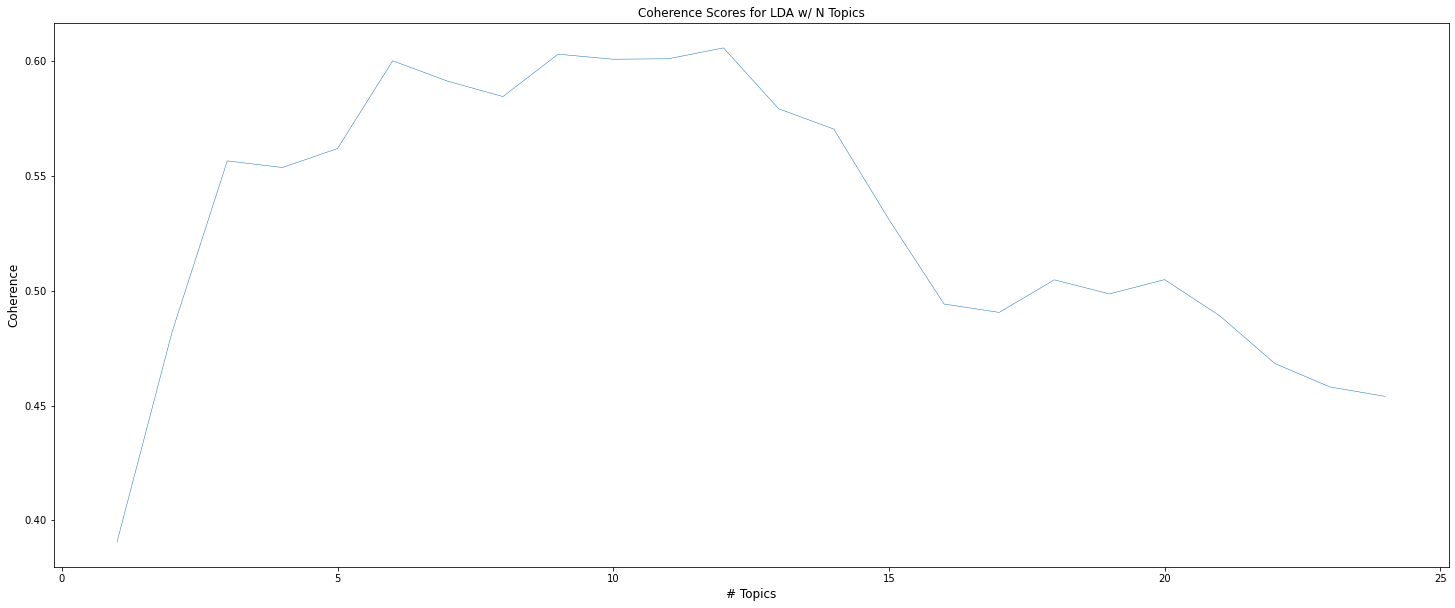

In [89]:
%%time

# Iterate to find optimal topics
scores = []

for n in range(1, 25, 1):

    model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            id2word = words,
                                            num_topics = n, 
                                            random_state = 100,
                                            update_every = 1,
                                            chunksize = 100,
                                            passes = 10,
                                            alpha = 'auto',
                                            per_word_topics = True)
    
    # Score (low = good)
    c = CoherenceModel(model = model, texts = df4['words'], dictionary = words, coherence = 'c_v')
    coherence = c.get_coherence()

    print(f'LDA for {n} topics, Coherence Score: ', coherence)

    scores.append((n, coherence))

fig, ax = plt.subplots(figsize = (25, 10))
plt.title('Coherence Scores for LDA w/ N Topics', fontsize = 12)
plt.xlabel('# Topics', fontsize = 12)
plt.ylabel('Coherence', fontsize = 12)
plt.plot([i[0] for i in scores], [i[1] for i in scores], lw = .5)
fig.show();

In [ ]:
# 12 topic optimal
model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                        id2word = words,
                                        num_topics = 12, 
                                        random_state = 100,
                                        update_every = 1,
                                        chunksize = 100,
                                        passes = 10,
                                        alpha = 'auto',)
                                        #per_word_topics = True)

In [ ]:
# Inspect
for index, topic in model.show_topics(formatted = False, num_words = 10):

    print('Topic: {} \nWords: {}'.format(index, ', '.join([w[0] for w in topic])))

In [ ]:
# Convert
topic_assignments = model.get_document_topics(corpus, minimum_probability = 0)
csr = gensim.matutils.corpus2csc(topic_assignments)
topic_array = csr.T.toarray()
topics = pd.DataFrame(topic_array)
topics.columns = [n for n in range(1, 13)]

In [ ]:
topics

In [ ]:
df5 = df4.reset_index()
df5['topic'] = topics.idxmax(axis = 1)

In [ ]:
df5 = df5.set_index('date', drop = True)

In [ ]:
df5['topic'].value_counts()

In [ ]:
df5.head()

[Back to top...](#top)

## GPT3: <a class = "anchor" id = "gpt"></a>

In [ ]:
# Group data by topic
#df5['wrds'] = df5['words'].apply(lambda x: ' '.join(x))
subject_matter = df5.groupby('topic')['wrds'].apply(' '.join)

In [ ]:
len(subject_matter)

In [ ]:
subject_matter[1]

In [ ]:
with open('openai.txt') as f:
    
    f = f.read()
    creds = ast.literal_eval(f)

In [ ]:
openai.organization = None
openai.api_key = creds['api_key']
engine_list = openai.Engine.list() 

In [184]:
engine_list

<OpenAIObject list at 0x7f7aafbfd040> JSON: {
  "data": [
    {
      "created": null,
      "id": "davinci-instruct-beta",
      "object": "engine",
      "owner": "openai",
      "permissions": null,
      "ready": true
    },
    {
      "created": null,
      "id": "text-search-babbage-query-001",
      "object": "engine",
      "owner": "openai-dev",
      "permissions": null,
      "ready": true
    },
    {
      "created": null,
      "id": "text-davinci-002",
      "object": "engine",
      "owner": "openai",
      "permissions": null,
      "ready": true
    },
    {
      "created": null,
      "id": "code-davinci-edit-001",
      "object": "engine",
      "owner": "openai",
      "permissions": null,
      "ready": true
    },
    {
      "created": null,
      "id": "babbage-search-document",
      "object": "engine",
      "owner": "openai-dev",
      "permissions": null,
      "ready": true
    },
    {
      "created": null,
      "id": "babbage-code-search-text",
     

In [ ]:
response = openai.Completion.create(engine = "davinci", 
                                    prompt = subject_matter[1][0:2049],
                                    temperature = 0.3,
                                    top_p = 1,
                                    frequency_penalty = 0,
                                    presence_penalty = 0)
print(response["choices"][0]["text"])

In [ ]:
response = openai.Completion.create(engine = "davinci", 
                                    prompt = subject_matter[2][0:2049],
                                    temperature = 0.3,
                                    top_p = 1,
                                    frequency_penalty = 0,
                                    presence_penalty = 0)
print(response["choices"][0]["text"])

In [ ]:
# Iterate
#n = 1

#for topic in subject_matter:
        
#    response = openai.Completion.create(engine = "davinci", 
#                                        prompt = topic[0:2049],
#                                        temperature = 0.3,
#                                        top_p = 1,
#                                        frequency_penalty = 0,
#                                        presence_penalty = 0)

#    print(f"Summarizing topic # {n}: {response['choices'][0]['text']}")
    
#    n += 1

[Back to top...](#top)

## FinTech: <a class = "anchor" id = "fintech"></a>

[Back to top...](#top)

## Conclusion: <a class = "anchor" id = "end"></a>

[Back to top...](#top)